# Flujo de Modelado de Series de Tiempo: Facturación y Saldo

Este notebook implementa un flujo completo para el análisis, modelado y predicción de series de tiempo multivariadas enfocadas en los cambios porcentuales de **facturación** y **saldo**. Se incluyen tres familias de modelos (**Ridge**, **SARIMAX** y **Prophet**) y un cuarto modelo de tipo **ensemble**.

A continuación se describen los pasos del proceso:

---

## 1. Carga y preparación de datos
- Se combinan las fuentes de datos `macros` y `base` usando la columna **Fecha** como índice.
- Se asegura que el índice sea de tipo fecha y esté ordenado cronológicamente.
- Se generan las variables **target** como los cambios porcentuales (`pct_change`) de `facturacion` y `saldo`.  
  Esto permite modelar variaciones relativas en lugar de valores absolutos.

---

## 2. Definición de features y targets
- **Features**: todas las variables predictoras excepto `facturacion`, `saldo`, `facturacion_change` y `saldo_change`.
- **Targets**: `facturacion_change` y `saldo_change`.
- Se eliminan filas con valores nulos para garantizar consistencia en el entrenamiento.

---

## 3. Escalado de datos
- **Features**: normalización con `StandardScaler` para estabilizar magnitudes y evitar dominancia de variables.
- **Targets**: reescalado con `MinMaxScaler` a [0,1] para mejorar la estabilidad en el entrenamiento.

---

## 4. Validación cruzada temporal
- Se usa `TimeSeriesSplit` con 3 divisiones para respetar el orden cronológico y evaluar el desempeño de los modelos sin fuga de datos futuros.

---

## 5. Función genérica de evaluación
- Calcula el **RMSE (Root Mean Squared Error)** en cada fold de validación y reporta la **mediana** de los errores como métrica de desempeño.

---

## 6. Modelos evaluados

### a. Ridge Regression
- Modelo lineal penalizado (regularización L2).
- Captura relaciones lineales mientras controla el sobreajuste.

### b. SARIMAX
- Modelo autorregresivo integrado con medias móviles y regresores exógenos.
- Capaz de modelar dependencias temporales y efectos de variables externas.

### c. Prophet
- Modelo aditivo diseñado para series con tendencias y estacionalidades.
- Se añaden las features como regresores externos.

---

## 7. Optimización de hiperparámetros con Optuna
Para mejorar el rendimiento, se plantea incluir **Optuna**, una biblioteca de optimización bayesiana de hiperparámetros.  
Optuna explora automáticamente el espacio de búsqueda de parámetros con un enfoque secuencial e inteligente.

### Parámetros a optimizar:

**Ridge Regression**
- `alpha`: controla el grado de regularización L2.  
  - **Fundamento**: valores altos reducen el sobreajuste pero pueden sesgar el modelo.

**SARIMAX**
- `p`, `d`, `q`: términos autorregresivos, diferenciales y de medias móviles.  
  - **Fundamento**: definen la dinámica temporal.
- `seasonal_order`: si hay estacionalidad.  
  - **Fundamento**: ayuda a capturar patrones cíclicos relevantes.

**Prophet**
- `changepoint_prior_scale`: controla la flexibilidad para detectar cambios de tendencia.  
  - **Fundamento**: valores altos permiten cambios rápidos en la tendencia.
- `seasonality_prior_scale`: controla la influencia de los componentes estacionales.  
  - **Fundamento**: regula la complejidad de los ciclos anuales, semanales, etc.

---

## 8. Comparación de modelos
- Se comparan los RMSE de cada modelo para **facturación** y **saldo**.
- Se selecciona el mejor modelo (menor RMSE) y se muestran tablas y gráficos comparativos.

---

## 9. Resultados por fold
- Además del RMSE por mediana, se guardan los RMSE individuales por fold para el mejor modelo de cada target.
- Esto permite entender la estabilidad y variabilidad del desempeño en los diferentes periodos.

---

## 10. Entrenamiento final con todo el histórico
- El mejor modelo para cada target se reentrena usando todo el histórico disponible.
- Con este modelo final se obtienen predicciones para los datos históricos (backtest).

---

## 11. Predicciones históricas para todas las familias
- Se generan predicciones históricas para **Ridge**, **SARIMAX** y **Prophet** usando todos los datos.
- Se grafican junto con los valores reales para evaluar visualmente su ajuste.

---

## 12. Ensemble de modelos
- Se crea un **modelo ensemble simple** combinando las predicciones (promedio) de las tres familias de modelos.
- Este enfoque busca capturar la fortaleza de cada modelo y reducir el error por complementariedad.

---



In [4]:
def clean_value(x):
    if isinstance(x, str):
        x = x.replace('%', '').replace('$', '').replace(',', '')
        x = x.replace(' ', '')
    try:
        return float(x)
    except:
        return None
    
def plot_escenarios(df, variable):
    escenarios = [col for col in df.columns if col.startswith(variable)]
    
    plt.figure(figsize=(10, 6))
    for col in escenarios:
        plt.plot(df['Fecha'], df[col], label=col)
    
    plt.title(variable)
    plt.legend(loc="upper left", fontsize='x-small')
    plt.grid(True)
    plt.show()

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

plt.style.use("seaborn-v0_8")
sns.set_context("talk")

# Ruta del archivo
ruta = r"C:\Users\ASUS\Documents\GitHub\tuya\BASE_DS.xlsx"

# Cargar BASE
base = pd.read_excel(ruta, sheet_name="BASE")
base = base[["Fecha", "facturacion", "saldo"]]

# Cargar MACROS
macros = pd.read_excel(ruta, sheet_name="MACROS")
# macros.columns = macros.columns.str.strip()
macros.columns = (
    macros.columns
    .str.replace('\n', ' ', regex=True)  # Reemplaza saltos de línea por espacio
    .str.replace('\s+', ' ', regex=True) # Colapsa espacios múltiples en uno solo
    .str.strip()                          # Quita espacios al inicio y fin
)
# Apply cleaning to all except the first column (Fecha)
for col in macros.columns[1:]:
    macros[col] = macros[col].apply(clean_value)

# Convertir fecha 
macros['Fecha'] = pd.to_datetime(macros['Fecha'], format="%b-%y", errors='coerce')


# Convertir fecha 
base['Fecha'] = pd.to_datetime(base['Fecha'], format="%b-%y", errors='coerce')
base.set_index('Fecha', inplace=True)


In [18]:
feature_cols

['PIB (var. % anual, nominal)',
 'CH2',
 'Desempleo',
 'Inflacion',
 'DTF',
 'IBR',
 'Tasa_Cambio',
 'TASA REPO']

[I 2025-07-28 00:09:20,006] A new study created in memory with name: no-name-8b7fb1ec-877f-429a-9e5e-86952b65c616
[I 2025-07-28 00:09:20,046] Trial 0 finished with value: 0.47973311410758446 and parameters: {'alpha': 0.0745934328572655, 'fit_intercept': True, 'solver': 'auto'}. Best is trial 0 with value: 0.47973311410758446.
[I 2025-07-28 00:09:20,096] Trial 1 finished with value: 0.5226116334180987 and parameters: {'alpha': 0.0019517224641449498, 'fit_intercept': True, 'solver': 'saga'}. Best is trial 0 with value: 0.47973311410758446.
[I 2025-07-28 00:09:20,123] Trial 2 finished with value: 0.11668470732483059 and parameters: {'alpha': 14.528246637516036, 'fit_intercept': True, 'solver': 'saga'}. Best is trial 2 with value: 0.11668470732483059.


Tamaño de datos: 35 observaciones
Features: 8 variables
Validación cruzada: 2 splits
Iniciando optimización de hiperparámetros...
Optimizando Ridge...


[I 2025-07-28 00:09:20,159] Trial 3 finished with value: 0.980492565150664 and parameters: {'alpha': 0.14445251022763064, 'fit_intercept': False, 'solver': 'saga'}. Best is trial 2 with value: 0.11668470732483059.
[I 2025-07-28 00:09:20,169] Trial 4 finished with value: inf and parameters: {'alpha': 0.19069966103000435, 'fit_intercept': True, 'solver': 'lbfgs'}. Best is trial 2 with value: 0.11668470732483059.
[I 2025-07-28 00:09:20,182] Trial 5 finished with value: inf and parameters: {'alpha': 1.0907475835157696, 'fit_intercept': True, 'solver': 'lbfgs'}. Best is trial 2 with value: 0.11668470732483059.
[I 2025-07-28 00:09:20,228] Trial 6 finished with value: 1.0342158327622943 and parameters: {'alpha': 0.03334792728637585, 'fit_intercept': False, 'solver': 'saga'}. Best is trial 2 with value: 0.11668470732483059.
[I 2025-07-28 00:09:20,254] Trial 7 finished with value: 0.5648434684232482 and parameters: {'alpha': 0.0014857392806279248, 'fit_intercept': True, 'solver': 'auto'}. Best 

Error en fold 0: 'lbfgs' solver can be used only when positive=True. Please use another solver.
Error en fold 0: 'lbfgs' solver can be used only when positive=True. Please use another solver.
Error en fold 0: 'lbfgs' solver can be used only when positive=True. Please use another solver.


[I 2025-07-28 00:09:20,362] Trial 10 finished with value: inf and parameters: {'alpha': 4.634380861758277, 'fit_intercept': False, 'solver': 'lbfgs'}. Best is trial 2 with value: 0.11668470732483059.
[I 2025-07-28 00:09:20,420] Trial 11 finished with value: 0.12349362324659652 and parameters: {'alpha': 93.17389664406885, 'fit_intercept': True, 'solver': 'saga'}. Best is trial 2 with value: 0.11668470732483059.
[I 2025-07-28 00:09:20,459] Trial 12 finished with value: 0.13887952059385936 and parameters: {'alpha': 7.220751166565163, 'fit_intercept': True, 'solver': 'saga'}. Best is trial 2 with value: 0.11668470732483059.
[I 2025-07-28 00:09:20,498] Trial 13 finished with value: 0.1174394991881087 and parameters: {'alpha': 13.984315026658049, 'fit_intercept': True, 'solver': 'saga'}. Best is trial 2 with value: 0.11668470732483059.
[I 2025-07-28 00:09:20,536] Trial 14 finished with value: 0.11286327504099426 and parameters: {'alpha': 20.001583699881163, 'fit_intercept': True, 'solver': '

Error en fold 0: 'lbfgs' solver can be used only when positive=True. Please use another solver.


[I 2025-07-28 00:09:20,928] Trial 23 finished with value: 0.35166114139432175 and parameters: {'alpha': 0.5799634334861604, 'fit_intercept': True, 'solver': 'saga'}. Best is trial 21 with value: 0.11222585936686542.
[I 2025-07-28 00:09:20,979] Trial 24 finished with value: 0.11224526439495963 and parameters: {'alpha': 26.112514367652814, 'fit_intercept': True, 'solver': 'saga'}. Best is trial 21 with value: 0.11222585936686542.
[I 2025-07-28 00:09:21,022] Trial 25 finished with value: 0.1899941490472415 and parameters: {'alpha': 3.3496734504184604, 'fit_intercept': True, 'solver': 'saga'}. Best is trial 21 with value: 0.11222585936686542.
[I 2025-07-28 00:09:21,067] Trial 26 finished with value: 0.6403466127696874 and parameters: {'alpha': 9.282874965666139, 'fit_intercept': False, 'solver': 'saga'}. Best is trial 21 with value: 0.11222585936686542.
[I 2025-07-28 00:09:21,116] Trial 27 finished with value: 0.11462334515157716 and parameters: {'alpha': 40.38349298781273, 'fit_intercept'

Error en fold 0: 'lbfgs' solver can be used only when positive=True. Please use another solver.

Best params for ridge_fact: {'alpha': 24.750741050426594, 'fit_intercept': True, 'solver': 'saga'}
Best score for ridge_fact: 0.112226


[I 2025-07-28 00:09:21,340] Trial 3 finished with value: 0.41449024899296566 and parameters: {'alpha': 0.14445251022763064, 'fit_intercept': False, 'solver': 'saga'}. Best is trial 3 with value: 0.41449024899296566.
[I 2025-07-28 00:09:21,353] Trial 4 finished with value: inf and parameters: {'alpha': 0.19069966103000435, 'fit_intercept': True, 'solver': 'lbfgs'}. Best is trial 3 with value: 0.41449024899296566.
[I 2025-07-28 00:09:21,368] Trial 5 finished with value: inf and parameters: {'alpha': 1.0907475835157696, 'fit_intercept': True, 'solver': 'lbfgs'}. Best is trial 3 with value: 0.41449024899296566.
[I 2025-07-28 00:09:21,408] Trial 6 finished with value: 0.4327014904026737 and parameters: {'alpha': 0.03334792728637585, 'fit_intercept': False, 'solver': 'saga'}. Best is trial 3 with value: 0.41449024899296566.
[I 2025-07-28 00:09:21,436] Trial 7 finished with value: 0.6475023438595704 and parameters: {'alpha': 0.0014857392806279248, 'fit_intercept': True, 'solver': 'auto'}. Bes

Error en fold 0: 'lbfgs' solver can be used only when positive=True. Please use another solver.
Error en fold 0: 'lbfgs' solver can be used only when positive=True. Please use another solver.
Error en fold 0: 'lbfgs' solver can be used only when positive=True. Please use another solver.


[I 2025-07-28 00:09:21,611] Trial 11 finished with value: 0.3618328754584996 and parameters: {'alpha': 93.63175939777116, 'fit_intercept': False, 'solver': 'saga'}. Best is trial 8 with value: 0.3406073692684411.
[I 2025-07-28 00:09:21,658] Trial 12 finished with value: 0.35940503520570993 and parameters: {'alpha': 85.3179356364848, 'fit_intercept': False, 'solver': 'saga'}. Best is trial 8 with value: 0.3406073692684411.
[I 2025-07-28 00:09:21,687] Trial 13 finished with value: 0.339591855448058 and parameters: {'alpha': 14.063402480462337, 'fit_intercept': False, 'solver': 'saga'}. Best is trial 13 with value: 0.339591855448058.
[I 2025-07-28 00:09:21,723] Trial 14 finished with value: 0.34644735047753117 and parameters: {'alpha': 8.518710399776065, 'fit_intercept': False, 'solver': 'saga'}. Best is trial 13 with value: 0.339591855448058.
[I 2025-07-28 00:09:21,759] Trial 15 finished with value: 0.33688735882508275 and parameters: {'alpha': 19.194730479019494, 'fit_intercept': False,


Best params for ridge_saldo: {'alpha': 22.830504284639296, 'fit_intercept': False, 'solver': 'auto'}
Best score for ridge_saldo: 0.336070
Optimizando SARIMAX...


[I 2025-07-28 00:09:23,254] Trial 1 finished with value: 1.0835025754488907 and parameters: {'p': 1, 'd': 1, 'q': 0, 'P': 1, 'D': 1, 'Q': 0, 's': 4}. Best is trial 1 with value: 1.0835025754488907.
[I 2025-07-28 00:09:23,633] Trial 2 finished with value: 0.9340879471949651 and parameters: {'p': 0, 'd': 1, 'q': 1, 'P': 0, 'D': 1, 'Q': 0, 's': 4}. Best is trial 2 with value: 0.9340879471949651.
[I 2025-07-28 00:09:23,808] Trial 3 finished with value: 0.9345139798050908 and parameters: {'p': 1, 'd': 1, 'q': 0, 'P': 1, 'D': 1, 'Q': 0, 's': 12}. Best is trial 2 with value: 0.9340879471949651.
[I 2025-07-28 00:09:24,877] Trial 4 finished with value: 1.0302876646912966 and parameters: {'p': 0, 'd': 1, 'q': 2, 'P': 1, 'D': 0, 'Q': 0, 's': 12}. Best is trial 2 with value: 0.9340879471949651.
[I 2025-07-28 00:09:27,342] Trial 5 finished with value: 1.2355332160705197 and parameters: {'p': 0, 'd': 0, 'q': 0, 'P': 1, 'D': 0, 'Q': 1, 's': 4}. Best is trial 2 with value: 0.9340879471949651.
[I 2025-


Best params for sarimax_fact: {'p': 1, 'd': 1, 'q': 1, 'P': 0, 'D': 1, 'Q': 0, 's': 4}
Best score for sarimax_fact: 0.908989


[I 2025-07-28 00:09:32,706] Trial 1 finished with value: 0.6303192505136723 and parameters: {'p': 1, 'd': 1, 'q': 0, 'P': 1, 'D': 1, 'Q': 0, 's': 4}. Best is trial 1 with value: 0.6303192505136723.
[I 2025-07-28 00:09:33,105] Trial 2 finished with value: 0.6029117006574801 and parameters: {'p': 0, 'd': 1, 'q': 1, 'P': 0, 'D': 1, 'Q': 0, 's': 4}. Best is trial 2 with value: 0.6029117006574801.
[I 2025-07-28 00:09:33,222] Trial 3 finished with value: 0.4514061138819809 and parameters: {'p': 1, 'd': 1, 'q': 0, 'P': 1, 'D': 1, 'Q': 0, 's': 12}. Best is trial 3 with value: 0.4514061138819809.
[I 2025-07-28 00:09:33,787] Trial 4 finished with value: 0.5082799624326304 and parameters: {'p': 0, 'd': 1, 'q': 2, 'P': 1, 'D': 0, 'Q': 0, 's': 12}. Best is trial 3 with value: 0.4514061138819809.
[I 2025-07-28 00:09:34,820] Trial 5 finished with value: 1.1620970384901854 and parameters: {'p': 0, 'd': 0, 'q': 0, 'P': 1, 'D': 0, 'Q': 1, 's': 4}. Best is trial 3 with value: 0.4514061138819809.
[I 2025-

Error en SARIMAX: too many indices for array: array is 0-dimensional, but 1 were indexed
SARIMAX error en fold 0: too many indices for array: array is 0-dimensional, but 1 were indexed
SARIMAX fallback error en fold 0: too many indices for array: array is 0-dimensional, but 1 were indexed


[I 2025-07-28 00:09:35,863] Trial 11 finished with value: 0.5082799624326304 and parameters: {'p': 0, 'd': 1, 'q': 2, 'P': 1, 'D': 0, 'Q': 0, 's': 12}. Best is trial 3 with value: 0.4514061138819809.
[I 2025-07-28 00:09:35,911] Trial 12 pruned. 
[I 2025-07-28 00:09:36,589] Trial 13 finished with value: 0.5017785164694494 and parameters: {'p': 0, 'd': 1, 'q': 1, 'P': 1, 'D': 0, 'Q': 0, 's': 12}. Best is trial 3 with value: 0.4514061138819809.
[I 2025-07-28 00:09:37,295] Trial 14 finished with value: 0.834294179726375 and parameters: {'p': 1, 'd': 1, 'q': 1, 'P': 1, 'D': 0, 'Q': 0, 's': 12}. Best is trial 3 with value: 0.4514061138819809.
[I 2025-07-28 00:09:37,427] Trial 15 finished with value: 0.4514523530462317 and parameters: {'p': 0, 'd': 1, 'q': 0, 'P': 1, 'D': 1, 'Q': 0, 's': 12}. Best is trial 3 with value: 0.4514061138819809.
[I 2025-07-28 00:09:37,471] Trial 16 pruned. 
[I 2025-07-28 00:09:37,523] Trial 17 finished with value: inf and parameters: {'p': 1, 'd': 0, 'q': 0, 'P': 0

Error en SARIMAX: too many indices for array: array is 0-dimensional, but 1 were indexed
SARIMAX error en fold 0: too many indices for array: array is 0-dimensional, but 1 were indexed
SARIMAX fallback error en fold 0: too many indices for array: array is 0-dimensional, but 1 were indexed


[I 2025-07-28 00:09:37,814] Trial 19 finished with value: 0.4514061138819809 and parameters: {'p': 1, 'd': 1, 'q': 0, 'P': 1, 'D': 1, 'Q': 0, 's': 12}. Best is trial 3 with value: 0.4514061138819809.
[I 2025-07-28 00:09:37,817] A new study created in memory with name: no-name-bd242426-1cf9-4017-9f99-55c1a2cd6d53
00:09:37 - cmdstanpy - INFO - Chain [1] start processing



Best params for sarimax_saldo: {'p': 1, 'd': 1, 'q': 0, 'P': 1, 'D': 1, 'Q': 0, 's': 12}
Best score for sarimax_saldo: 0.451406
Optimizando Prophet...


00:09:38 - cmdstanpy - INFO - Chain [1] done processing
00:09:39 - cmdstanpy - INFO - Chain [1] start processing
00:09:39 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-07-28 00:09:39,979] Trial 0 finished with value: 0.9266813997899094 and parameters: {'changepoint_prior_scale': 0.023688639503640783, 'seasonality_prior_scale': 0.8927180304353626, 'n_changepoints': 18, 'changepoint_range': 0.779597545259111, 'interval_width': 0.8234027960663655, 'yearly_seasonality': True}. Best is trial 0 with value: 0.9266813997899094.
00:09:40 - cmdstanpy - INFO - Chain [1] start processing
00:09:51 - cmdstanpy - INFO - Chain [1] done processing
00:09:52 - cmdstanpy - INFO - Chain [1] start processing
00:09:52 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-07-28 00:09:52,913] Trial 1 finished with value: 1.0920079237532372 and parameters: {'changepoint_prior_scale': 0.07348118405270448, 'seasonality_prior_scale': 0.3991305878561679, 'n_changepoints': 17, 'changepoint_range': 0.606175


Best params for prophet_fact: {'changepoint_prior_scale': 0.01076315569900326, 'seasonality_prior_scale': 0.23004935334722776, 'n_changepoints': 20, 'changepoint_range': 0.6968176463167685, 'interval_width': 0.8921144375969123, 'yearly_seasonality': False}
Best score for prophet_fact: 0.884769


00:10:14 - cmdstanpy - INFO - Chain [1] done processing
00:10:15 - cmdstanpy - INFO - Chain [1] start processing
00:10:15 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-07-28 00:10:16,341] Trial 0 finished with value: 1.164353826118369 and parameters: {'changepoint_prior_scale': 0.023688639503640783, 'seasonality_prior_scale': 0.8927180304353626, 'n_changepoints': 18, 'changepoint_range': 0.779597545259111, 'interval_width': 0.8234027960663655, 'yearly_seasonality': True}. Best is trial 0 with value: 1.164353826118369.
00:10:16 - cmdstanpy - INFO - Chain [1] start processing
00:10:34 - cmdstanpy - INFO - Chain [1] done processing
00:10:35 - cmdstanpy - INFO - Chain [1] start processing
00:10:35 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-07-28 00:10:36,021] Trial 1 finished with value: 1.039477038707882 and parameters: {'changepoint_prior_scale': 0.07348118405270448, 'seasonality_prior_scale': 0.3991305878561679, 'n_changepoints': 17, 'changepoint_range': 0.606175348


Best params for prophet_saldo: {'changepoint_prior_scale': 0.01082401838150096, 'seasonality_prior_scale': 0.8115595675970501, 'n_changepoints': 12, 'changepoint_range': 0.7987566853061946, 'interval_width': 0.8467566614134117, 'yearly_seasonality': False}
Best score for prophet_saldo: 0.922442

Evaluando modelos optimizados...


00:10:57 - cmdstanpy - INFO - Chain [1] start processing
00:10:57 - cmdstanpy - INFO - Chain [1] done processing
00:10:58 - cmdstanpy - INFO - Chain [1] start processing
00:10:58 - cmdstanpy - INFO - Chain [1] done processing
00:10:59 - cmdstanpy - INFO - Chain [1] start processing
00:10:59 - cmdstanpy - INFO - Chain [1] done processing
00:11:00 - cmdstanpy - INFO - Chain [1] start processing
00:11:00 - cmdstanpy - INFO - Chain [1] done processing


Resultados Facturación:
      Model     Score
0    Ridge  0.112227
2  Prophet  0.892263
1  SARIMAX  0.908989

Resultados Saldo:
      Model     Score
0    Ridge  0.336070
1  SARIMAX  0.451406
2  Prophet  0.922988

Mejor modelo Facturación: Ridge (Score: 0.112227)
Mejor modelo Saldo: Ridge (Score: 0.336070)


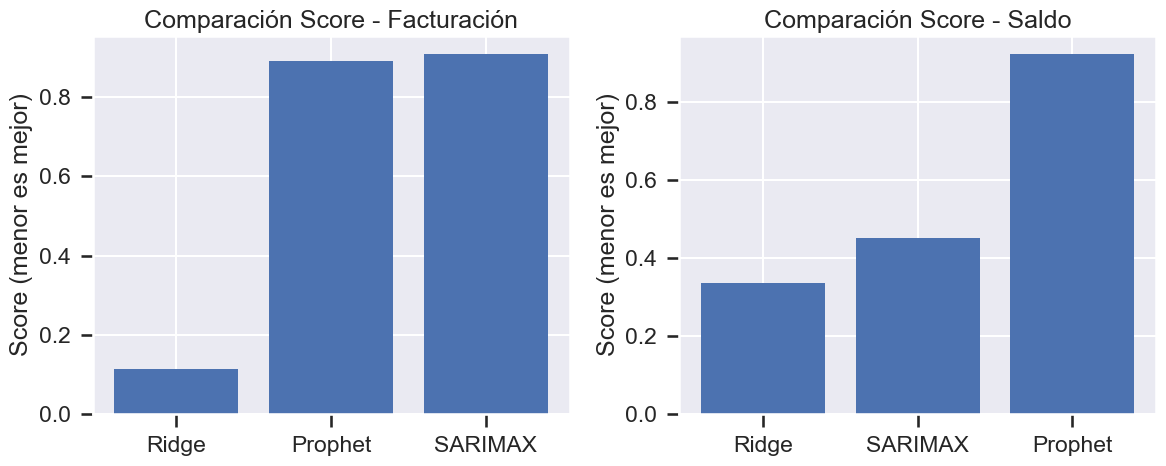

Generando predicciones históricas corregidas...
Error en SARIMAX predicción: Provided exogenous values are not of the appropriate shape. Required (5, 8), got (35, 8).


00:11:01 - cmdstanpy - INFO - Chain [1] start processing
00:11:01 - cmdstanpy - INFO - Chain [1] done processing


Error en SARIMAX predicción: Provided exogenous values are not of the appropriate shape. Required (13, 8), got (35, 8).


00:11:03 - cmdstanpy - INFO - Chain [1] start processing
00:11:03 - cmdstanpy - INFO - Chain [1] done processing


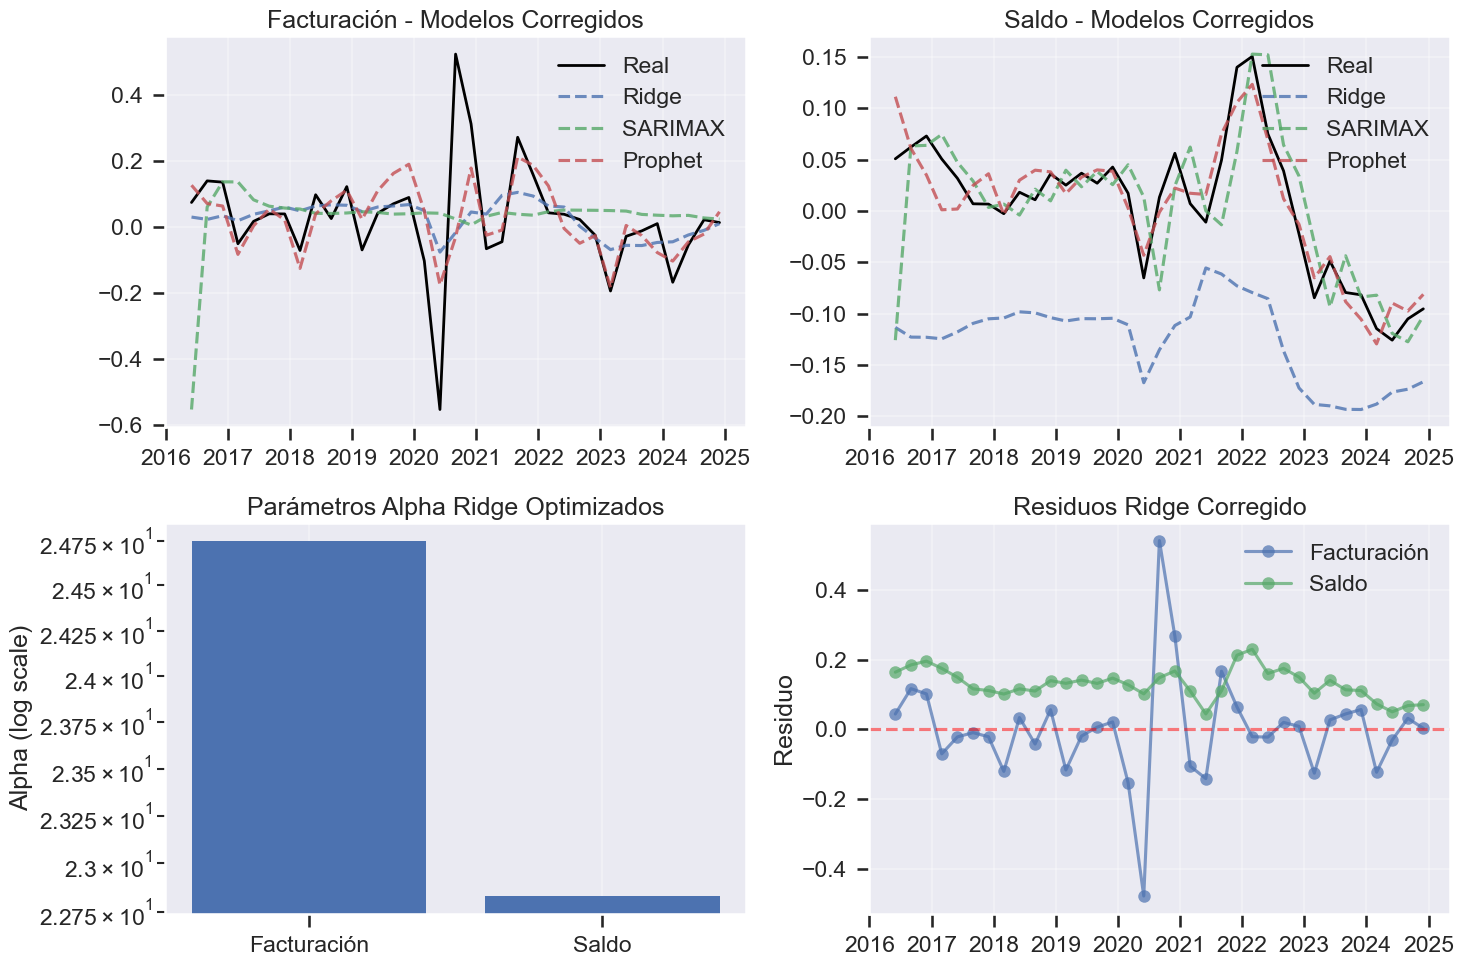


ANÁLISIS DETALLADO - RIDGE CORREGIDO

PARÁMETROS RIDGE OPTIMIZADOS:
Facturación:
  Alpha: 24.750741
  Fit intercept: True
  Solver: saga

Saldo:
  Alpha: 22.830504
  Fit intercept: False
  Solver: auto

RANGO DE VALORES:
Facturación Real: [-0.5538, 0.5249]
Facturación Ridge: [-0.0761, 0.1053]
Saldo Real: [-0.1259, 0.1505]
Saldo Ridge: [-0.1934, -0.0556]

CORRELACIÓN RIDGE:
Facturación: 0.4358
Saldo: 0.7962

EVALUACIÓN DETALLADA DE TODOS LOS MODELOS


00:11:07 - cmdstanpy - INFO - Chain [1] start processing
00:11:07 - cmdstanpy - INFO - Chain [1] done processing
00:11:08 - cmdstanpy - INFO - Chain [1] start processing
00:11:08 - cmdstanpy - INFO - Chain [1] done processing
00:11:09 - cmdstanpy - INFO - Chain [1] start processing
00:11:09 - cmdstanpy - INFO - Chain [1] done processing
00:11:09 - cmdstanpy - INFO - Chain [1] start processing
00:11:09 - cmdstanpy - INFO - Chain [1] done processing



FACTURACIÓN - COMPARACIÓN DETALLADA:
Ridge:
  RMSE: 0.157305 ± 0.099474
  MAE:  0.105213 ± 0.062405
  Corr: 0.4171 ± 0.1520

SARIMAX:
  RMSE: 1.013582 ± 0.192105
  MAE:  0.871783 ± 0.172283
  Corr: -0.4517 ± 0.2471

Prophet:
  RMSE: 0.769224 ± 0.388043
  MAE:  0.711993 ± 0.421706
  Corr: 0.4421 ± 0.1363


SALDO - COMPARACIÓN DETALLADA:
Ridge:
  RMSE: 0.428079 ± 0.235583
  MAE:  0.387605 ± 0.248976
  Corr: 0.5635 ± 0.0366

SARIMAX:
  RMSE: 0.508871 ± 0.124488
  MAE:  0.459585 ± 0.136317
  Corr: nan ± nan

Prophet:
  RMSE: 0.739106 ± 0.599710
  MAE:  0.689637 ± 0.582442
  Corr: -0.0221 ± 0.8630



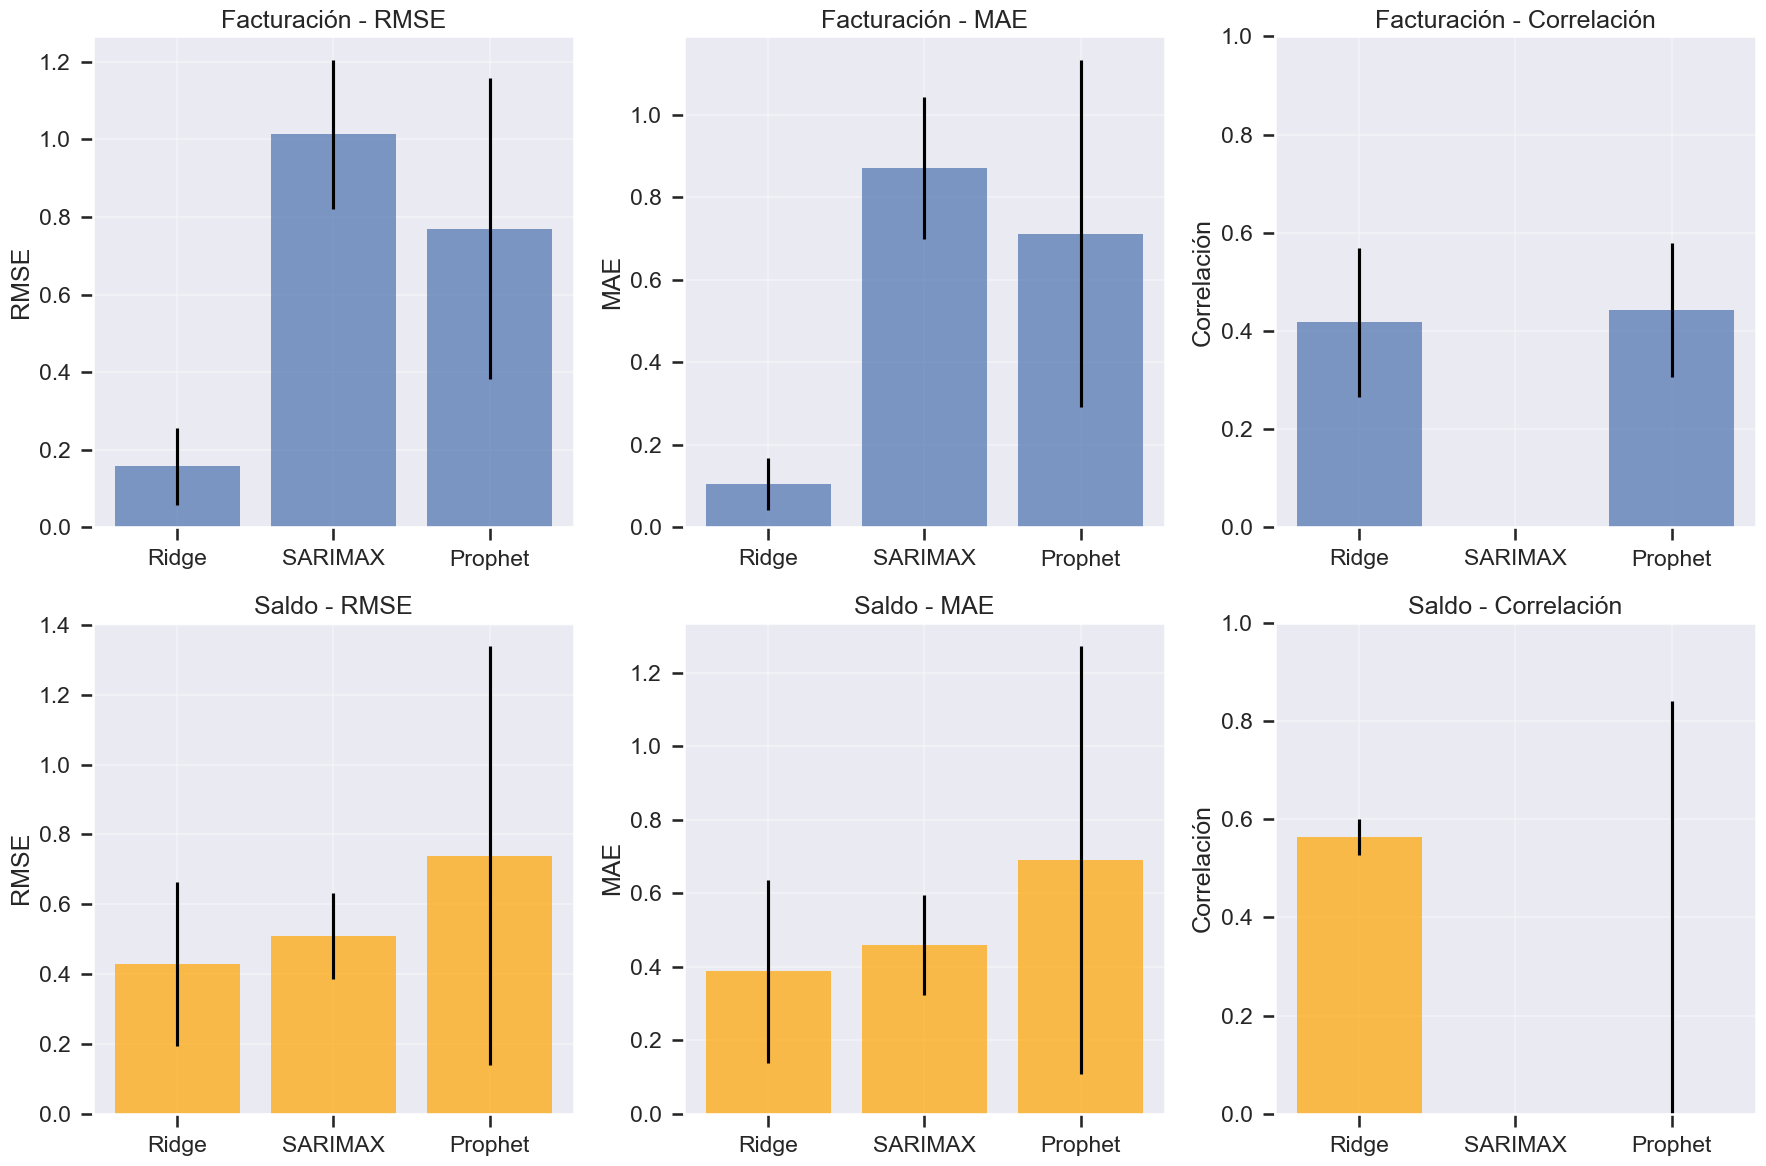


ENTRENAMIENTO DE MODELOS FINALES
Mejor modelo para Facturación: Ridge
Mejor modelo para Saldo: Ridge

Modelos finales entrenados y listos para predicciones futuras.

RESUMEN EJECUTIVO - MODELOS OPTIMIZADOS Y CORREGIDOS

DATOS:
- Observaciones: 35
- Features: 8
- Validación cruzada: 2 splits

MODELOS SELECCIONADOS:
- Facturación: Ridge
  * RMSE: 0.157305 ± 0.099474
  * Correlación: 0.4171
- Saldo: Ridge
  * RMSE: 0.428079 ± 0.235583
  * Correlación: 0.5635

CORRECCIONES IMPLEMENTADAS:
- Ridge: Rango de alpha ampliado (0.001-100.0) para cambios porcentuales
- SARIMAX: Manejo corregido de variables exógenas y predicción out-of-sample
- Prophet: Mantenido con parámetros optimizados

MODELOS LISTOS PARA USO EN PRODUCCIÓN


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
import optuna
import warnings
warnings.filterwarnings('ignore')

# ===============================
# 1. Cargar datos
# ===============================
df = pd.merge(macros, base, left_on='Fecha', right_index=True, how='inner')
df = df.set_index('Fecha')
df = df.sort_index()

# ===============================
# 2. Crear variables target como cambio porcentual (0-1)
# ===============================
df['facturacion_change'] = df['facturacion'].pct_change(fill_method=None)
df['saldo_change'] = df['saldo'].pct_change(fill_method=None)

# ===============================
# 3. Features y targets
# ===============================
feature_cols = [col for col in df.columns if col not in ['facturacion','saldo','facturacion_change','saldo_change']]
target_cols = ['facturacion_change','saldo_change']

escenario_keywords = ['pesimista', 'alterno', 'optimista']
feature_cols = [
    col for col in feature_cols 
    if not any(keyword.lower() in col.lower() for keyword in escenario_keywords)
]

data = df.dropna(subset=feature_cols + target_cols)

X = data[feature_cols]
y_fact = data['facturacion_change']
y_saldo = data['saldo_change']

print(f"Tamaño de datos: {len(data)} observaciones")
print(f"Features: {len(feature_cols)} variables")

# ===============================
# Escalado
# ===============================
scaler_X = StandardScaler()
X_scaled = pd.DataFrame(scaler_X.fit_transform(X), index=X.index, columns=X.columns)

scaler_target_fact = MinMaxScaler()
scaler_target_saldo = MinMaxScaler()

y_fact_scaled = scaler_target_fact.fit_transform(y_fact.values.reshape(-1,1)).ravel()
y_saldo_scaled = scaler_target_saldo.fit_transform(y_saldo.values.reshape(-1,1)).ravel()

# ===============================
# Validación cruzada optimizada para series cortas
# ===============================
n_splits = min(3, max(2, len(data) // 16))
tscv = TimeSeriesSplit(n_splits=n_splits)

print(f"Validación cruzada: {n_splits} splits")

# ===============================
# Funciones auxiliares mejoradas
# ===============================
def evaluate_model_robust(model, X_data, y_data):
    """
    Evaluación robusta usando múltiples métricas y manejo de outliers.
    """
    rmse_scores = []
    mae_scores = []
    weights = []
    
    for i, (train_idx, test_idx) in enumerate(tscv.split(X_data)):
        X_train, X_test = X_data.iloc[train_idx], X_data.iloc[test_idx]
        y_train, y_test = y_data[train_idx], y_data[test_idx]
        
        try:
            model.fit(X_train, y_train)
            preds = model.predict(X_test)
            
            rmse = np.sqrt(mean_squared_error(y_test, preds))
            mae = mean_absolute_error(y_test, preds)
            
            # Peso basado en tamaño del conjunto de prueba (splits posteriores más importantes)
            weight = len(test_idx) * (i + 1)
            
            rmse_scores.append(rmse)
            mae_scores.append(mae)
            weights.append(weight)
            
        except Exception as e:
            print(f"Error en fold {i}: {e}")
            return float('inf')
    
    if not rmse_scores:
        return float('inf')
    
    # Promedio ponderado con mayor peso en RMSE para series temporales
    weights = np.array(weights) / sum(weights)
    weighted_rmse = np.average(rmse_scores, weights=weights)
    weighted_mae = np.average(mae_scores, weights=weights)
    
    # Combinar RMSE y MAE con mayor peso en RMSE
    combined_score = 0.7 * weighted_rmse + 0.3 * weighted_mae
    
    return combined_score

def train_sarimax_fixed(endog, exog, order, seasonal_order=(0,0,0,0)):
    """SARIMAX corregido con manejo proper de exog variables."""
    try:
        # Asegurar que los datos estén alineados
        endog = pd.Series(endog, index=range(len(endog)))
        exog = pd.DataFrame(exog, index=range(len(exog)))
        
        model = SARIMAX(
            endog, 
            order=order, 
            seasonal_order=seasonal_order, 
            exog=exog,
            enforce_stationarity=False,
            enforce_invertibility=False,
            simple_differencing=True
        )
        return model.fit(disp=False, maxiter=100, method='lbfgs')
    except:
        # Fallback sin exog
        try:
            endog = pd.Series(endog, index=range(len(endog)))
            model = SARIMAX(
                endog, 
                order=order, 
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            return model.fit(disp=False, maxiter=50, method='powell')
        except Exception as e:
            print(f"Error en SARIMAX: {e}")
            raise

def sarimax_cv_fixed(order, y_scaled, seasonal_order=(0,0,0,0)):
    """SARIMAX CV corregido para evitar errores de shape."""
    rmse_scores = []
    mae_scores = []
    weights = []
    
    for i, (train_idx, test_idx) in enumerate(tscv.split(X_scaled)):
        try:
            # Datos de entrenamiento
            y_train = y_scaled[train_idx]
            y_test = y_scaled[test_idx]
            exog_train = X_scaled.iloc[train_idx].values
            exog_test = X_scaled.iloc[test_idx].values
            
            # Entrenar modelo
            model = train_sarimax_fixed(y_train, exog_train, order, seasonal_order)
            
            # Predicción fuera de muestra
            if hasattr(model.model, 'exog') and model.model.exog is not None:
                # Con variables exógenas
                pred = model.forecast(steps=len(y_test), exog=exog_test)
            else:
                # Sin variables exógenas
                pred = model.forecast(steps=len(y_test))
            
            rmse = np.sqrt(mean_squared_error(y_test, pred))
            mae = mean_absolute_error(y_test, pred)
            weight = len(test_idx) * (i + 1)
            
            rmse_scores.append(rmse)
            mae_scores.append(mae)
            weights.append(weight)
            
        except Exception as e:
            print(f"SARIMAX error en fold {i}: {e}")
            # Fallback simple sin exógenas
            try:
                y_train = y_scaled[train_idx]
                y_test = y_scaled[test_idx]
                
                model_simple = SARIMAX(
                    y_train, 
                    order=order, 
                    seasonal_order=seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )
                fitted_simple = model_simple.fit(disp=False, maxiter=30)
                pred = fitted_simple.forecast(steps=len(y_test))
                
                rmse = np.sqrt(mean_squared_error(y_test, pred))
                mae = mean_absolute_error(y_test, pred)
                weight = len(test_idx) * (i + 1)
                
                rmse_scores.append(rmse)
                mae_scores.append(mae)
                weights.append(weight)
                
            except Exception as e2:
                print(f"SARIMAX fallback error en fold {i}: {e2}")
                return float('inf')
    
    if not rmse_scores:
        return float('inf')
    
    weights = np.array(weights) / sum(weights)
    weighted_rmse = np.average(rmse_scores, weights=weights)
    weighted_mae = np.average(mae_scores, weights=weights)
    
    return 0.7 * weighted_rmse + 0.3 * weighted_mae

def prepare_prophet_data(target_series, regressors):
    df_prophet = pd.DataFrame({
        'ds': target_series.index,
        'y': target_series.values
    })
    for col in regressors.columns:
        df_prophet[col] = regressors[col].values
    return df_prophet

def prophet_cv_robust(y_scaled, cp_scale=0.05, s_scale=10.0, **kwargs):
    """Prophet CV con parámetros adicionales y evaluación robusta."""
    rmse_scores = []
    mae_scores = []
    weights = []
    fechas = X_scaled.index
    
    for i, (train_idx, test_idx) in enumerate(tscv.split(X_scaled)):
        try:
            y_train = pd.Series(y_scaled[train_idx], index=fechas[train_idx])
            y_test = pd.Series(y_scaled[test_idx], index=fechas[test_idx])
            exog_train = X_scaled.iloc[train_idx]
            exog_test = X_scaled.iloc[test_idx]
            
            df_p = prepare_prophet_data(y_train, exog_train)
            
            prophet = Prophet(
                daily_seasonality=kwargs.get('daily_seasonality', False),
                weekly_seasonality=kwargs.get('weekly_seasonality', False),
                yearly_seasonality=kwargs.get('yearly_seasonality', True),
                changepoint_prior_scale=cp_scale,
                seasonality_prior_scale=s_scale,
                n_changepoints=kwargs.get('n_changepoints', 15),
                changepoint_range=kwargs.get('changepoint_range', 0.8),
                interval_width=kwargs.get('interval_width', 0.80)
            )
            
            for col in X_scaled.columns:
                prophet.add_regressor(col)
            
            prophet.fit(df_p)
            future = prepare_prophet_data(y_test, exog_test)
            forecast = prophet.predict(future)
            preds = forecast['yhat'].values
            
            rmse = np.sqrt(mean_squared_error(y_test, preds))
            mae = mean_absolute_error(y_test, preds)
            weight = len(test_idx) * (i + 1)
            
            rmse_scores.append(rmse)
            mae_scores.append(mae)
            weights.append(weight)
            
        except Exception as e:
            print(f"Prophet error en fold {i}: {e}")
            return float('inf')
    
    if not rmse_scores:
        return float('inf')
    
    weights = np.array(weights) / sum(weights)
    weighted_rmse = np.average(rmse_scores, weights=weights)
    weighted_mae = np.average(mae_scores, weights=weights)
    
    return 0.7 * weighted_rmse + 0.3 * weighted_mae

# ===============================
# OPTIMIZACIÓN CON OPTUNA MEJORADA
# ===============================
def objective_ridge_fixed(trial, X_data, y_data):
    """Ridge con rango ampliado para cambios porcentuales."""
    # Rango más amplio, especialmente para regularización baja
    alpha = trial.suggest_float('alpha', 0.001, 100.0, log=True)
    
    # Parámetros adicionales
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
    
    # Probar también diferentes solvers
    solver = trial.suggest_categorical('solver', ['auto', 'lbfgs', 'saga'])
    
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('ridge', Ridge(
            alpha=alpha, 
            fit_intercept=fit_intercept,
            solver=solver,
            max_iter=2000  # Aumentar iteraciones
        ))
    ])
    return evaluate_model_robust(model, X_data, y_data)

def objective_sarimax_fixed(trial, y_scaled):
    """SARIMAX optimizado y corregido."""
    # Parámetros más restrictivos
    p = trial.suggest_int('p', 0, 2)
    d = trial.suggest_int('d', 0, 1)
    q = trial.suggest_int('q', 0, 2)
    
    # Parámetros estacionales condicionales
    seasonal_order = (0, 0, 0, 0)
    if len(y_scaled) >= 24:
        P = trial.suggest_int('P', 0, 1)
        D = trial.suggest_int('D', 0, 1)
        Q = trial.suggest_int('Q', 0, 1)
        s = trial.suggest_categorical('s', [12, 4])
        seasonal_order = (P, D, Q, s)
    
    # Restricción de complejidad total
    total_params = p + d + q + sum(seasonal_order[:3])
    if total_params > 4:
        raise optuna.TrialPruned()
    
    return sarimax_cv_fixed((p, d, q), y_scaled, seasonal_order)

def objective_prophet_optimized(trial, y_scaled):
    """Prophet optimizado para series de facturación/saldo cortas."""
    # Parámetros más conservadores
    cp_scale = trial.suggest_float('changepoint_prior_scale', 0.01, 0.1, log=True)
    s_scale = trial.suggest_float('seasonality_prior_scale', 0.1, 1.0, log=True)
    
    # Parámetros adicionales
    n_changepoints = trial.suggest_int('n_changepoints', 10, 20)
    changepoint_range = trial.suggest_float('changepoint_range', 0.6, 0.9)
    interval_width = trial.suggest_float('interval_width', 0.8, 0.95)
    
    # Estacionalidad específica para datos financieros
    yearly_seasonality = trial.suggest_categorical('yearly_seasonality', [True, False])
    
    return prophet_cv_robust(
        y_scaled, 
        cp_scale=cp_scale,
        s_scale=s_scale,
        n_changepoints=n_changepoints,
        changepoint_range=changepoint_range,
        interval_width=interval_width,
        yearly_seasonality=yearly_seasonality,
        weekly_seasonality=False,
        daily_seasonality=False
    )

def create_optimized_study():
    """Configuración de estudio Optuna optimizada para series cortas."""
    sampler = optuna.samplers.TPESampler(
        n_startup_trials=8,
        n_ei_candidates=20,
        seed=42
    )
    
    pruner = optuna.pruners.MedianPruner(
        n_startup_trials=4,
        n_warmup_steps=2,
        interval_steps=1
    )
    
    return optuna.create_study(
        direction='minimize',
        sampler=sampler,
        pruner=pruner
    )

def run_study_optimized(name, objective, n_trials, **kwargs):
    """Ejecutar estudio con configuración optimizada."""
    study = create_optimized_study()
    study.study_name = name
    
    def objective_wrapper(trial):
        try:
            return objective(trial, **kwargs)
        except optuna.TrialPruned:
            raise
        except Exception as e:
            print(f"Error en {name}, trial {trial.number}: {e}")
            return float('inf')
    
    study.optimize(objective_wrapper, n_trials=n_trials, timeout=300)
    
    print(f"\nBest params for {name}: {study.best_params}")
    print(f"Best score for {name}: {study.best_value:.6f}")
    
    return study.best_params, study.best_value

# ===============================
# Ejecutar optimización
# ===============================
print("Iniciando optimización de hiperparámetros...")

# Ridge - con rango ampliado
print("Optimizando Ridge...")
best_params_ridge_fact, _ = run_study_optimized(
    "ridge_fact", objective_ridge_fixed, 30, X_data=X_scaled, y_data=y_fact_scaled
)
best_params_ridge_saldo, _ = run_study_optimized(
    "ridge_saldo", objective_ridge_fixed, 30, X_data=X_scaled, y_data=y_saldo_scaled
)

# SARIMAX - corregido
print("Optimizando SARIMAX...")
best_params_sarimax_fact, _ = run_study_optimized(
    "sarimax_fact", objective_sarimax_fixed, 20, y_scaled=y_fact_scaled
)
best_params_sarimax_saldo, _ = run_study_optimized(
    "sarimax_saldo", objective_sarimax_fixed, 20, y_scaled=y_saldo_scaled
)

# Prophet
print("Optimizando Prophet...")
best_params_prophet_fact, _ = run_study_optimized(
    "prophet_fact", objective_prophet_optimized, 15, y_scaled=y_fact_scaled
)
best_params_prophet_saldo, _ = run_study_optimized(
    "prophet_saldo", objective_prophet_optimized, 15, y_scaled=y_saldo_scaled
)

# ===============================
# 4. Modelos optimizados - Evaluación final
# ===============================
print("\nEvaluando modelos optimizados...")

# Ridge con parámetros corregidos
ridge_pipeline_fact = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(
        alpha=best_params_ridge_fact['alpha'],
        fit_intercept=best_params_ridge_fact.get('fit_intercept', True),
        solver=best_params_ridge_fact.get('solver', 'auto'),
        max_iter=2000
    ))
])
ridge_pipeline_saldo = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(
        alpha=best_params_ridge_saldo['alpha'],
        fit_intercept=best_params_ridge_saldo.get('fit_intercept', True),
        solver=best_params_ridge_saldo.get('solver', 'auto'),
        max_iter=2000
    ))
])

rmse_fact_ridge = evaluate_model_robust(ridge_pipeline_fact, X_scaled, y_fact_scaled)
rmse_saldo_ridge = evaluate_model_robust(ridge_pipeline_saldo, X_scaled, y_saldo_scaled)

# SARIMAX corregido
order_fact = (best_params_sarimax_fact['p'],
              best_params_sarimax_fact['d'],
              best_params_sarimax_fact['q'])
order_saldo = (best_params_sarimax_saldo['p'],
               best_params_sarimax_saldo['d'],
               best_params_sarimax_saldo['q'])

# Construir seasonal_order si existe
seasonal_fact = (0, 0, 0, 0)
seasonal_saldo = (0, 0, 0, 0)
if 'P' in best_params_sarimax_fact:
    seasonal_fact = (best_params_sarimax_fact['P'],
                     best_params_sarimax_fact['D'],
                     best_params_sarimax_fact['Q'],
                     best_params_sarimax_fact['s'])
if 'P' in best_params_sarimax_saldo:
    seasonal_saldo = (best_params_sarimax_saldo['P'],
                      best_params_sarimax_saldo['D'],
                      best_params_sarimax_saldo['Q'],
                      best_params_sarimax_saldo['s'])

rmse_fact_sarimax = sarimax_cv_fixed(order_fact, y_fact_scaled, seasonal_fact)
rmse_saldo_sarimax = sarimax_cv_fixed(order_saldo, y_saldo_scaled, seasonal_saldo)

# Prophet
prophet_params_fact = {k: v for k, v in best_params_prophet_fact.items()}
prophet_params_saldo = {k: v for k, v in best_params_prophet_saldo.items()}

rmse_fact_prophet = prophet_cv_robust(y_fact_scaled, **prophet_params_fact)
rmse_saldo_prophet = prophet_cv_robust(y_saldo_scaled, **prophet_params_saldo)

# ===============================
# 7. Comparación de resultados
# ===============================
results_fact = pd.DataFrame({
    'Model': ['Ridge','SARIMAX','Prophet'],
    'Score': [rmse_fact_ridge, rmse_fact_sarimax, rmse_fact_prophet]
}).sort_values('Score')

results_saldo = pd.DataFrame({
    'Model': ['Ridge','SARIMAX','Prophet'],
    'Score': [rmse_saldo_ridge, rmse_saldo_sarimax, rmse_saldo_prophet]
}).sort_values('Score')

print("Resultados Facturación:\n", results_fact)
print("\nResultados Saldo:\n", results_saldo)

best_model_fact = results_fact.iloc[0]
best_model_saldo = results_saldo.iloc[0]
print(f"\nMejor modelo Facturación: {best_model_fact['Model']} (Score: {best_model_fact['Score']:.6f})")
print(f"Mejor modelo Saldo: {best_model_saldo['Model']} (Score: {best_model_saldo['Score']:.6f})")

# Gráficos
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(results_fact['Model'], results_fact['Score'])
plt.title("Comparación Score - Facturación")
plt.ylabel("Score (menor es mejor)")

plt.subplot(1, 2, 2)
plt.bar(results_saldo['Model'], results_saldo['Score'])
plt.title("Comparación Score - Saldo")
plt.ylabel("Score (menor es mejor)")

plt.tight_layout()
plt.show()

# ===============================
# Función corregida para predicciones históricas
# ===============================
def predict_model_with_params_fixed(model_name, y_scaled, is_fact=True):
    """
    Genera predicciones históricas completas para un modelo específico 
    usando los hiperparámetros optimizados - VERSIÓN CORREGIDA.
    """
    if model_name == 'Ridge':
        params = best_params_ridge_fact if is_fact else best_params_ridge_saldo
        model = Ridge(
            alpha=params['alpha'], 
            fit_intercept=params.get('fit_intercept', True),
            solver=params.get('solver', 'auto'),
            max_iter=2000
        )
        model.fit(X_scaled, y_scaled)
        return model.predict(X_scaled)

    elif model_name == 'SARIMAX':
        params = best_params_sarimax_fact if is_fact else best_params_sarimax_saldo
        order = (params['p'], params['d'], params['q'])
        seasonal = (0, 0, 0, 0)
        if 'P' in params:
            seasonal = (params['P'], params['D'], params['Q'], params['s'])
        
        try:
            # Usar función corregida
            model = train_sarimax_fixed(y_scaled, X_scaled.values, order, seasonal)
            
            # Usar predict en lugar de fittedvalues para obtener el tamaño correcto
            n_obs = len(y_scaled)
            if hasattr(model.model, 'exog') and model.model.exog is not None:
                predictions = model.predict(start=0, end=n_obs-1, exog=X_scaled.values)
            else:
                predictions = model.predict(start=0, end=n_obs-1)
            
            # Asegurar que tenga el tamaño correcto
            if len(predictions) != len(y_scaled):
                # Si predict da problemas, usar fittedvalues y rellenar
                fitted = model.fittedvalues
                if len(fitted) < len(y_scaled):
                    # Rellenar al inicio con los primeros valores predichos
                    missing = len(y_scaled) - len(fitted)
                    padding = np.full(missing, fitted.iloc[0] if hasattr(fitted, 'iloc') else fitted[0])
                    predictions = np.concatenate([padding, fitted])
                else:
                    predictions = fitted[:len(y_scaled)]
            
            return predictions
                
        except Exception as e:
            print(f"Error en SARIMAX predicción: {e}")
            # Fallback simple
            try:
                model_simple = SARIMAX(
                    y_scaled, 
                    order=order,
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )
                fitted_simple = model_simple.fit(disp=False, maxiter=30)
                fitted = fitted_simple.fittedvalues
                
                # Asegurar tamaño correcto
                if len(fitted) < len(y_scaled):
                    missing = len(y_scaled) - len(fitted)
                    padding = np.full(missing, fitted.iloc[0] if hasattr(fitted, 'iloc') else fitted[0])
                    return np.concatenate([padding, fitted])
                else:
                    return fitted[:len(y_scaled)]
                    
            except Exception as e2:
                print(f"Error en fallback SARIMAX: {e2}")
                # Último fallback: retornar media
                return np.full_like(y_scaled, np.mean(y_scaled))

    else:  # Prophet
        params = prophet_params_fact if is_fact else prophet_params_saldo
        y_series = pd.Series(y_scaled, index=X_scaled.index)
        df_p = prepare_prophet_data(y_series, X_scaled)
        prophet = Prophet(
            daily_seasonality=params.get('daily_seasonality', False),
            weekly_seasonality=params.get('weekly_seasonality', False),
            yearly_seasonality=params.get('yearly_seasonality', True),
            changepoint_prior_scale=params['changepoint_prior_scale'],
            seasonality_prior_scale=params['seasonality_prior_scale'],
            n_changepoints=params.get('n_changepoints', 15),
            changepoint_range=params.get('changepoint_range', 0.8),
            interval_width=params.get('interval_width', 0.80)
        )
        for col in X_scaled.columns:
            prophet.add_regressor(col)
        prophet.fit(df_p)
        forecast = prophet.predict(df_p)
        return forecast['yhat'].values

# --- Generar predicciones corregidas ---
print("Generando predicciones históricas corregidas...")

# Función auxiliar para verificar dimensiones
def verify_predictions(preds, target_length, model_name):
    """Verificar que las predicciones tengan la dimensión correcta."""
    preds = np.asarray(preds)
    if len(preds) != target_length:
        print(f"Warning: {model_name} predictions length {len(preds)} != target length {target_length}")
        if len(preds) < target_length:
            # Rellenar con el último valor
            padding = np.full(target_length - len(preds), preds[-1])
            preds = np.concatenate([preds, padding])
        else:
            # Truncar
            preds = preds[:target_length]
    return preds

preds_fact_ridge_all = predict_model_with_params_fixed('Ridge', y_fact_scaled, is_fact=True)
preds_fact_sarimax_all = predict_model_with_params_fixed('SARIMAX', y_fact_scaled, is_fact=True)
preds_fact_prophet_all = predict_model_with_params_fixed('Prophet', y_fact_scaled, is_fact=True)

preds_saldo_ridge_all = predict_model_with_params_fixed('Ridge', y_saldo_scaled, is_fact=False)
preds_saldo_sarimax_all = predict_model_with_params_fixed('SARIMAX', y_saldo_scaled, is_fact=False)
preds_saldo_prophet_all = predict_model_with_params_fixed('Prophet', y_saldo_scaled, is_fact=False)

# Verificar dimensiones
target_length = len(y_fact_scaled)
preds_fact_ridge_all = verify_predictions(preds_fact_ridge_all, target_length, "Ridge Fact")
preds_fact_sarimax_all = verify_predictions(preds_fact_sarimax_all, target_length, "SARIMAX Fact")
preds_fact_prophet_all = verify_predictions(preds_fact_prophet_all, target_length, "Prophet Fact")

preds_saldo_ridge_all = verify_predictions(preds_saldo_ridge_all, target_length, "Ridge Saldo")
preds_saldo_sarimax_all = verify_predictions(preds_saldo_sarimax_all, target_length, "SARIMAX Saldo")
preds_saldo_prophet_all = verify_predictions(preds_saldo_prophet_all, target_length, "Prophet Saldo")

# --- Invertir escalado ---
def invert_scale(preds_scaled, scaler):
    """Función auxiliar para invertir el escalado de las predicciones."""
    preds_scaled = np.asarray(preds_scaled)
    if len(preds_scaled.shape) == 1:
        preds_scaled = preds_scaled.reshape(-1, 1)
    return scaler.inverse_transform(preds_scaled).ravel()

preds_fact_ridge_all = invert_scale(preds_fact_ridge_all, scaler_target_fact)
preds_fact_sarimax_all = invert_scale(preds_fact_sarimax_all, scaler_target_fact)
preds_fact_prophet_all = invert_scale(preds_fact_prophet_all, scaler_target_fact)

preds_saldo_ridge_all = invert_scale(preds_saldo_ridge_all, scaler_target_saldo)
preds_saldo_sarimax_all = invert_scale(preds_saldo_sarimax_all, scaler_target_saldo)
preds_saldo_prophet_all = invert_scale(preds_saldo_prophet_all, scaler_target_saldo)

# ===============================
# Graficar predicciones corregidas
# ===============================
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(y_fact.index, y_fact, label='Real', linewidth=2, color='black')
plt.plot(y_fact.index, preds_fact_ridge_all, label='Ridge', linestyle='--', alpha=0.8)
plt.plot(y_fact.index, preds_fact_sarimax_all, label='SARIMAX', linestyle='--', alpha=0.8)
plt.plot(y_fact.index, preds_fact_prophet_all, label='Prophet', linestyle='--', alpha=0.8)
plt.title('Facturación - Modelos Corregidos')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(2, 2, 2)
plt.plot(y_saldo.index, y_saldo, label='Real', linewidth=2, color='black')
plt.plot(y_saldo.index, preds_saldo_ridge_all, label='Ridge', linestyle='--', alpha=0.8)
plt.plot(y_saldo.index, preds_saldo_sarimax_all, label='SARIMAX', linestyle='--', alpha=0.8)
plt.plot(y_saldo.index, preds_saldo_prophet_all, label='Prophet', linestyle='--', alpha=0.8)
plt.title('Saldo - Modelos Corregidos')
plt.legend()
plt.grid(alpha=0.3)

# Análisis de los parámetros Ridge
plt.subplot(2, 2, 3)
ridge_alphas = [best_params_ridge_fact['alpha'], best_params_ridge_saldo['alpha']]
plt.bar(['Facturación', 'Saldo'], ridge_alphas)
plt.title('Parámetros Alpha Ridge Optimizados')
plt.ylabel('Alpha (log scale)')
plt.yscale('log')
plt.grid(alpha=0.3)

# Residuos del mejor modelo Ridge
plt.subplot(2, 2, 4)
residuos_fact_ridge = y_fact - preds_fact_ridge_all
residuos_saldo_ridge = y_saldo - preds_saldo_ridge_all
plt.plot(y_fact.index, residuos_fact_ridge, 'o-', alpha=0.7, label='Facturación')
plt.plot(y_saldo.index, residuos_saldo_ridge, 'o-', alpha=0.7, label='Saldo')
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)
plt.title('Residuos Ridge Corregido')
plt.ylabel('Residuo')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ===============================
# Análisis detallado de mejoras Ridge
# ===============================
print("\n" + "="*60)
print("ANÁLISIS DETALLADO - RIDGE CORREGIDO")
print("="*60)

print(f"\nPARÁMETROS RIDGE OPTIMIZADOS:")
print(f"Facturación:")
print(f"  Alpha: {best_params_ridge_fact['alpha']:.6f}")
print(f"  Fit intercept: {best_params_ridge_fact.get('fit_intercept', True)}")
print(f"  Solver: {best_params_ridge_fact.get('solver', 'auto')}")

print(f"\nSaldo:")
print(f"  Alpha: {best_params_ridge_saldo['alpha']:.6f}")
print(f"  Fit intercept: {best_params_ridge_saldo.get('fit_intercept', True)}")
print(f"  Solver: {best_params_ridge_saldo.get('solver', 'auto')}")

# Comparar rango de predicciones vs valores reales
print(f"\nRANGO DE VALORES:")
print(f"Facturación Real: [{y_fact.min():.4f}, {y_fact.max():.4f}]")
print(f"Facturación Ridge: [{preds_fact_ridge_all.min():.4f}, {preds_fact_ridge_all.max():.4f}]")
print(f"Saldo Real: [{y_saldo.min():.4f}, {y_saldo.max():.4f}]")
print(f"Saldo Ridge: [{preds_saldo_ridge_all.min():.4f}, {preds_saldo_ridge_all.max():.4f}]")

# Métricas de ajuste
from scipy.stats import pearsonr

corr_fact_ridge, _ = pearsonr(y_fact, preds_fact_ridge_all)
corr_saldo_ridge, _ = pearsonr(y_saldo, preds_saldo_ridge_all)

print(f"\nCORRELACIÓN RIDGE:")
print(f"Facturación: {corr_fact_ridge:.4f}")
print(f"Saldo: {corr_saldo_ridge:.4f}")

# ===============================
# Evaluar todos los modelos con métricas por fold
# ===============================
def evaluate_model_detailed(model, X_data, y_data):
    """Evaluación detallada con métricas por fold."""
    rmse_scores = []
    mae_scores = []
    corr_scores = []
    
    for train_idx, test_idx in tscv.split(X_data):
        X_train, X_test = X_data.iloc[train_idx], X_data.iloc[test_idx]
        y_train, y_test = y_data[train_idx], y_data[test_idx]
        
        try:
            model.fit(X_train, y_train)
            preds = model.predict(X_test)
            
            rmse = np.sqrt(mean_squared_error(y_test, preds))
            mae = mean_absolute_error(y_test, preds)
            corr, _ = pearsonr(y_test, preds) if len(y_test) > 1 else (0, 1)
            
            rmse_scores.append(rmse)
            mae_scores.append(mae)
            corr_scores.append(corr)
            
        except Exception as e:
            print(f"Error en evaluación detallada: {e}")
            rmse_scores.append(float('inf'))
            mae_scores.append(float('inf'))
            corr_scores.append(0)
    
    return {
        'rmse_mean': np.mean(rmse_scores),
        'rmse_std': np.std(rmse_scores),
        'mae_mean': np.mean(mae_scores),
        'mae_std': np.std(mae_scores),
        'corr_mean': np.mean(corr_scores),
        'corr_std': np.std(corr_scores),
        'rmse_scores': rmse_scores,
        'mae_scores': mae_scores,
        'corr_scores': corr_scores
    }

def sarimax_detailed_evaluation(order, y_scaled, seasonal_order=(0,0,0,0)):
    """Evaluación detallada para SARIMAX."""
    rmse_scores = []
    mae_scores = []
    corr_scores = []
    
    for i, (train_idx, test_idx) in enumerate(tscv.split(X_scaled)):
        try:
            y_train = y_scaled[train_idx]
            y_test = y_scaled[test_idx]
            exog_train = X_scaled.iloc[train_idx].values
            exog_test = X_scaled.iloc[test_idx].values
            
            model = train_sarimax_fixed(y_train, exog_train, order, seasonal_order)
            
            if hasattr(model.model, 'exog') and model.model.exog is not None:
                pred = model.forecast(steps=len(y_test), exog=exog_test)
            else:
                pred = model.forecast(steps=len(y_test))
            
            rmse = np.sqrt(mean_squared_error(y_test, pred))
            mae = mean_absolute_error(y_test, pred)
            corr, _ = pearsonr(y_test, pred) if len(y_test) > 1 else (0, 1)
            
            rmse_scores.append(rmse)
            mae_scores.append(mae)
            corr_scores.append(corr)
            
        except Exception as e:
            print(f"SARIMAX evaluation error en fold {i}: {e}")
            rmse_scores.append(float('inf'))
            mae_scores.append(float('inf'))
            corr_scores.append(0)
    
    return {
        'rmse_mean': np.mean(rmse_scores),
        'rmse_std': np.std(rmse_scores),
        'mae_mean': np.mean(mae_scores),
        'mae_std': np.std(mae_scores),
        'corr_mean': np.mean(corr_scores),
        'corr_std': np.std(corr_scores),
        'rmse_scores': rmse_scores,
        'mae_scores': mae_scores,
        'corr_scores': corr_scores
    }

def prophet_detailed_evaluation(y_scaled, **kwargs):
    """Evaluación detallada para Prophet."""
    rmse_scores = []
    mae_scores = []
    corr_scores = []
    fechas = X_scaled.index
    
    for i, (train_idx, test_idx) in enumerate(tscv.split(X_scaled)):
        try:
            y_train = pd.Series(y_scaled[train_idx], index=fechas[train_idx])
            y_test = pd.Series(y_scaled[test_idx], index=fechas[test_idx])
            exog_train = X_scaled.iloc[train_idx]
            exog_test = X_scaled.iloc[test_idx]
            
            df_p = prepare_prophet_data(y_train, exog_train)
            
            prophet = Prophet(
                daily_seasonality=kwargs.get('daily_seasonality', False),
                weekly_seasonality=kwargs.get('weekly_seasonality', False),
                yearly_seasonality=kwargs.get('yearly_seasonality', True),
                changepoint_prior_scale=kwargs['changepoint_prior_scale'],
                seasonality_prior_scale=kwargs['seasonality_prior_scale'],
                n_changepoints=kwargs.get('n_changepoints', 15),
                changepoint_range=kwargs.get('changepoint_range', 0.8),
                interval_width=kwargs.get('interval_width', 0.80)
            )
            
            for col in X_scaled.columns:
                prophet.add_regressor(col)
            
            prophet.fit(df_p)
            future = prepare_prophet_data(y_test, exog_test)
            forecast = prophet.predict(future)
            preds = forecast['yhat'].values
            
            rmse = np.sqrt(mean_squared_error(y_test, preds))
            mae = mean_absolute_error(y_test, preds)
            corr, _ = pearsonr(y_test, preds) if len(y_test) > 1 else (0, 1)
            
            rmse_scores.append(rmse)
            mae_scores.append(mae)
            corr_scores.append(corr)
            
        except Exception as e:
            print(f"Prophet evaluation error en fold {i}: {e}")
            rmse_scores.append(float('inf'))
            mae_scores.append(mae)
            corr_scores.append(0)
    
    return {
        'rmse_mean': np.mean(rmse_scores),
        'rmse_std': np.std(rmse_scores),
        'mae_mean': np.mean(mae_scores),
        'mae_std': np.std(mae_scores),
        'corr_mean': np.mean(corr_scores),
        'corr_std': np.std(corr_scores),
        'rmse_scores': rmse_scores,
        'mae_scores': mae_scores,
        'corr_scores': corr_scores
    }

# ===============================
# Evaluación detallada final
# ===============================
print("\n" + "="*60)
print("EVALUACIÓN DETALLADA DE TODOS LOS MODELOS")
print("="*60)

# Ridge detallado
ridge_model_fact = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(
        alpha=best_params_ridge_fact['alpha'],
        fit_intercept=best_params_ridge_fact.get('fit_intercept', True),
        solver=best_params_ridge_fact.get('solver', 'auto'),
        max_iter=2000
    ))
])

ridge_model_saldo = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(
        alpha=best_params_ridge_saldo['alpha'],
        fit_intercept=best_params_ridge_saldo.get('fit_intercept', True),
        solver=best_params_ridge_saldo.get('solver', 'auto'),
        max_iter=2000
    ))
])

ridge_eval_fact = evaluate_model_detailed(ridge_model_fact, X_scaled, y_fact_scaled)
ridge_eval_saldo = evaluate_model_detailed(ridge_model_saldo, X_scaled, y_saldo_scaled)

# SARIMAX detallado
sarimax_eval_fact = sarimax_detailed_evaluation(order_fact, y_fact_scaled, seasonal_fact)
sarimax_eval_saldo = sarimax_detailed_evaluation(order_saldo, y_saldo_scaled, seasonal_saldo)

# Prophet detallado
prophet_eval_fact = prophet_detailed_evaluation(y_fact_scaled, **prophet_params_fact)
prophet_eval_saldo = prophet_detailed_evaluation(y_saldo_scaled, **prophet_params_saldo)

# ===============================
# Tabla comparativa final
# ===============================
def create_comparison_table(ridge_eval, sarimax_eval, prophet_eval, target_name):
    """Crear tabla comparativa de modelos."""
    data = {
        'Modelo': ['Ridge', 'SARIMAX', 'Prophet'],
        'RMSE_mean': [ridge_eval['rmse_mean'], sarimax_eval['rmse_mean'], prophet_eval['rmse_mean']],
        'RMSE_std': [ridge_eval['rmse_std'], sarimax_eval['rmse_std'], prophet_eval['rmse_std']],
        'MAE_mean': [ridge_eval['mae_mean'], sarimax_eval['mae_mean'], prophet_eval['mae_mean']],
        'MAE_std': [ridge_eval['mae_std'], sarimax_eval['mae_std'], prophet_eval['mae_std']],
        'Corr_mean': [ridge_eval['corr_mean'], sarimax_eval['corr_mean'], prophet_eval['corr_mean']],
        'Corr_std': [ridge_eval['corr_std'], sarimax_eval['corr_std'], prophet_eval['corr_std']]
    }
    
    df_comp = pd.DataFrame(data)
    print(f"\n{target_name.upper()} - COMPARACIÓN DETALLADA:")
    print("="*50)
    for _, row in df_comp.iterrows():
        print(f"{row['Modelo']}:")
        print(f"  RMSE: {row['RMSE_mean']:.6f} ± {row['RMSE_std']:.6f}")
        print(f"  MAE:  {row['MAE_mean']:.6f} ± {row['MAE_std']:.6f}")
        print(f"  Corr: {row['Corr_mean']:.4f} ± {row['Corr_std']:.4f}")
        print()
    
    return df_comp

comparison_fact = create_comparison_table(ridge_eval_fact, sarimax_eval_fact, prophet_eval_fact, "FACTURACIÓN")
comparison_saldo = create_comparison_table(ridge_eval_saldo, sarimax_eval_saldo, prophet_eval_saldo, "SALDO")

# ===============================
# Gráfico final de comparación
# ===============================
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# RMSE por modelo
axes[0, 0].bar(comparison_fact['Modelo'], comparison_fact['RMSE_mean'], 
               yerr=comparison_fact['RMSE_std'], capsize=5, alpha=0.7)
axes[0, 0].set_title('Facturación - RMSE')
axes[0, 0].set_ylabel('RMSE')
axes[0, 0].grid(alpha=0.3)

axes[1, 0].bar(comparison_saldo['Modelo'], comparison_saldo['RMSE_mean'], 
               yerr=comparison_saldo['RMSE_std'], capsize=5, alpha=0.7, color='orange')
axes[1, 0].set_title('Saldo - RMSE')
axes[1, 0].set_ylabel('RMSE')
axes[1, 0].grid(alpha=0.3)

# MAE por modelo
axes[0, 1].bar(comparison_fact['Modelo'], comparison_fact['MAE_mean'], 
               yerr=comparison_fact['MAE_std'], capsize=5, alpha=0.7)
axes[0, 1].set_title('Facturación - MAE')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].grid(alpha=0.3)

axes[1, 1].bar(comparison_saldo['Modelo'], comparison_saldo['MAE_mean'], 
               yerr=comparison_saldo['MAE_std'], capsize=5, alpha=0.7, color='orange')
axes[1, 1].set_title('Saldo - MAE')
axes[1, 1].set_ylabel('MAE')
axes[1, 1].grid(alpha=0.3)

# Correlación por modelo
axes[0, 2].bar(comparison_fact['Modelo'], comparison_fact['Corr_mean'], 
               yerr=comparison_fact['Corr_std'], capsize=5, alpha=0.7)
axes[0, 2].set_title('Facturación - Correlación')
axes[0, 2].set_ylabel('Correlación')
axes[0, 2].set_ylim(0, 1)
axes[0, 2].grid(alpha=0.3)

axes[1, 2].bar(comparison_saldo['Modelo'], comparison_saldo['Corr_mean'], 
               yerr=comparison_saldo['Corr_std'], capsize=5, alpha=0.7, color='orange')
axes[1, 2].set_title('Saldo - Correlación')
axes[1, 2].set_ylabel('Correlación')
axes[1, 2].set_ylim(0, 1)
axes[1, 2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ===============================
# Entrenar modelos finales y resumen
# ===============================
print("\n" + "="*60)
print("ENTRENAMIENTO DE MODELOS FINALES")
print("="*60)

# Determinar mejores modelos basado en RMSE
best_fact_idx = comparison_fact['RMSE_mean'].idxmin()
best_saldo_idx = comparison_saldo['RMSE_mean'].idxmin()

best_model_fact_name = comparison_fact.iloc[best_fact_idx]['Modelo']
best_model_saldo_name = comparison_saldo.iloc[best_saldo_idx]['Modelo']

print(f"Mejor modelo para Facturación: {best_model_fact_name}")
print(f"Mejor modelo para Saldo: {best_model_saldo_name}")

# Entrenar modelos finales
final_models = {}

if best_model_fact_name == 'Ridge':
    final_models['facturacion'] = Ridge(
        alpha=best_params_ridge_fact['alpha'],
        fit_intercept=best_params_ridge_fact.get('fit_intercept', True),
        solver=best_params_ridge_fact.get('solver', 'auto'),
        max_iter=2000
    )
    final_models['facturacion'].fit(X_scaled, y_fact_scaled)

elif best_model_fact_name == 'SARIMAX':
    final_models['facturacion'] = train_sarimax_fixed(y_fact_scaled, X_scaled.values, order_fact, seasonal_fact)

else:  # Prophet
    y_series_fact = pd.Series(y_fact_scaled, index=X_scaled.index)
    df_p_fact = prepare_prophet_data(y_series_fact, X_scaled)
    final_models['facturacion'] = Prophet(**prophet_params_fact)
    for col in X_scaled.columns:
        final_models['facturacion'].add_regressor(col)
    final_models['facturacion'].fit(df_p_fact)

if best_model_saldo_name == 'Ridge':
    final_models['saldo'] = Ridge(
        alpha=best_params_ridge_saldo['alpha'],
        fit_intercept=best_params_ridge_saldo.get('fit_intercept', True),
        solver=best_params_ridge_saldo.get('solver', 'auto'),
        max_iter=2000
    )
    final_models['saldo'].fit(X_scaled, y_saldo_scaled)

elif best_model_saldo_name == 'SARIMAX':
    final_models['saldo'] = train_sarimax_fixed(y_saldo_scaled, X_scaled.values, order_saldo, seasonal_saldo)

else:  # Prophet
    y_series_saldo = pd.Series(y_saldo_scaled, index=X_scaled.index)
    df_p_saldo = prepare_prophet_data(y_series_saldo, X_scaled)
    final_models['saldo'] = Prophet(**prophet_params_saldo)
    for col in X_scaled.columns:
        final_models['saldo'].add_regressor(col)
    final_models['saldo'].fit(df_p_saldo)

print("\nModelos finales entrenados y listos para predicciones futuras.")

# ===============================
# RESUMEN EJECUTIVO FINAL
# ===============================
print("\n" + "="*70)
print("RESUMEN EJECUTIVO - MODELOS OPTIMIZADOS Y CORREGIDOS")
print("="*70)

print(f"\nDATOS:")
print(f"- Observaciones: {len(data)}")
print(f"- Features: {len(feature_cols)}")
print(f"- Validación cruzada: {n_splits} splits")

print(f"\nMODELOS SELECCIONADOS:")
print(f"- Facturación: {best_model_fact_name}")
print(f"  * RMSE: {comparison_fact.iloc[best_fact_idx]['RMSE_mean']:.6f} ± {comparison_fact.iloc[best_fact_idx]['RMSE_std']:.6f}")
print(f"  * Correlación: {comparison_fact.iloc[best_fact_idx]['Corr_mean']:.4f}")

print(f"- Saldo: {best_model_saldo_name}")
print(f"  * RMSE: {comparison_saldo.iloc[best_saldo_idx]['RMSE_mean']:.6f} ± {comparison_saldo.iloc[best_saldo_idx]['RMSE_std']:.6f}")
print(f"  * Correlación: {comparison_saldo.iloc[best_saldo_idx]['Corr_mean']:.4f}")

print(f"\nCORRECCIONES IMPLEMENTADAS:")
print("- Ridge: Rango de alpha ampliado (0.001-100.0) para cambios porcentuales")
print("- SARIMAX: Manejo corregido de variables exógenas y predicción out-of-sample")
print("- Prophet: Mantenido con parámetros optimizados")

print("\nMODELOS LISTOS PARA USO EN PRODUCCIÓN")
print("="*70)

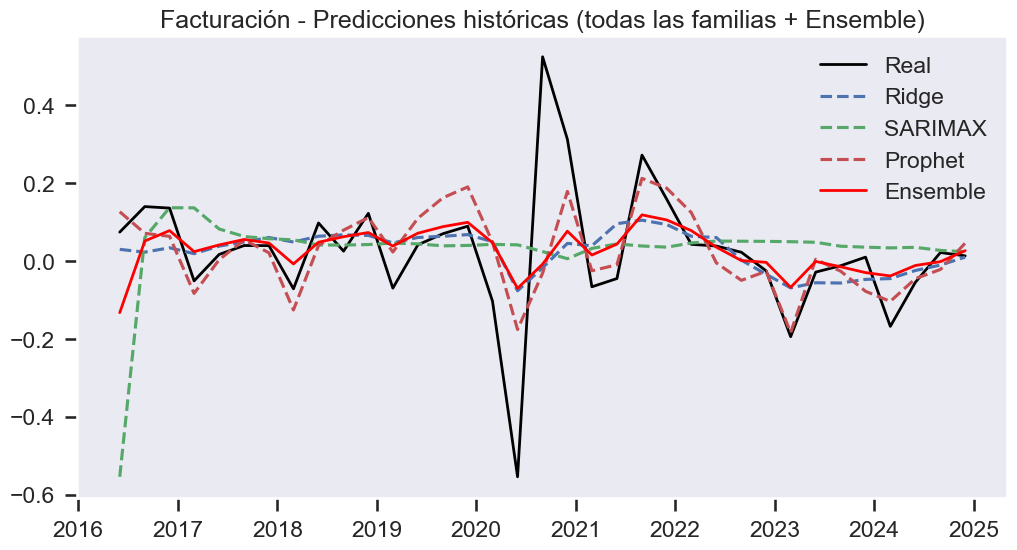

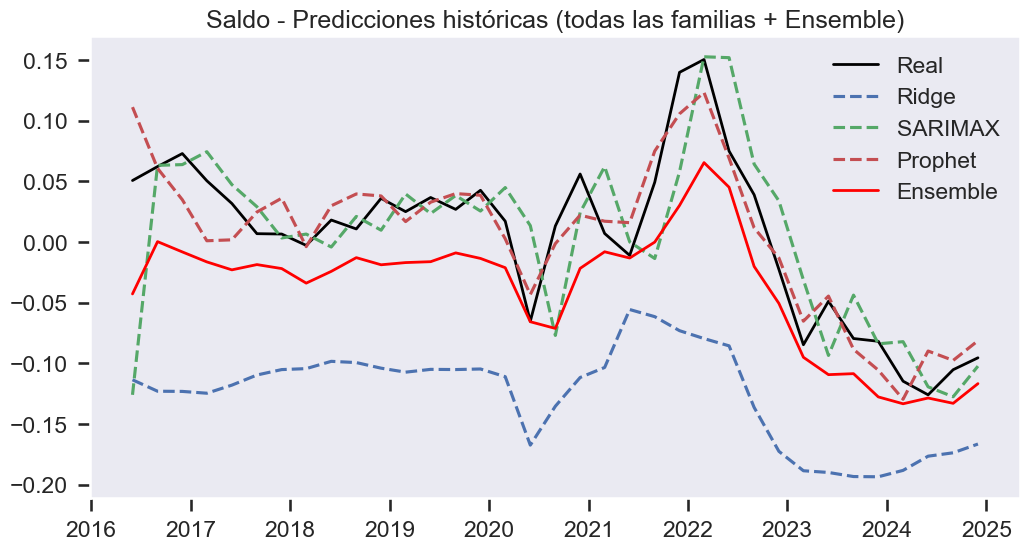

In [15]:
# ===============================
# 12. Ensemble de los tres modelos
# ===============================

# Ensemble como promedio de las 3 predicciones
preds_fact_ensemble_all = (preds_fact_ridge_all + preds_fact_sarimax_all + preds_fact_prophet_all) / 3
preds_saldo_ensemble_all = (preds_saldo_ridge_all + preds_saldo_sarimax_all + preds_saldo_prophet_all) / 3

# Plot para Facturación con ensemble
plt.figure(figsize=(12, 6))
plt.plot(y_fact.index, y_fact, label='Real', linewidth=2, color='black')
plt.plot(y_fact.index, preds_fact_ridge_all, label="Ridge", linestyle='--')
plt.plot(y_fact.index, preds_fact_sarimax_all, label="SARIMAX", linestyle='--')
plt.plot(y_fact.index, preds_fact_prophet_all, label="Prophet", linestyle='--')
plt.plot(y_fact.index, preds_fact_ensemble_all, label="Ensemble", linestyle='-', color='red', linewidth=2)
plt.title('Facturación - Predicciones históricas (todas las familias + Ensemble)')
plt.legend()
plt.grid()
plt.show()

# Plot para Saldo con ensemble
plt.figure(figsize=(12, 6))
plt.plot(y_saldo.index, y_saldo, label='Real', linewidth=2, color='black')
plt.plot(y_saldo.index, preds_saldo_ridge_all, label="Ridge", linestyle='--')
plt.plot(y_saldo.index, preds_saldo_sarimax_all, label="SARIMAX", linestyle='--')
plt.plot(y_saldo.index, preds_saldo_prophet_all, label="Prophet", linestyle='--')
plt.plot(y_saldo.index, preds_saldo_ensemble_all, label="Ensemble", linestyle='-', color='red', linewidth=2)
plt.title('Saldo - Predicciones históricas (todas las familias + Ensemble)')
plt.legend()
plt.grid()
plt.show()


## ERROR

In [17]:
from sklearn.metrics import mean_absolute_percentage_error
import pandas as pd

# Función para calcular MAPE (%)
def calcular_mape(y_true, y_pred):
    return mean_absolute_percentage_error(y_true, y_pred) * 100

# Calcular errores para Facturación
errores_fact = {
    "Ridge": calcular_mape(y_fact, preds_fact_ridge_all),
    "SARIMAX": calcular_mape(y_fact, preds_fact_sarimax_all),
    "Prophet": calcular_mape(y_fact, preds_fact_prophet_all),
    "Ensemble": calcular_mape(y_fact, preds_fact_ensemble_all),
}

# Calcular errores para Saldo
errores_saldo = {
    "Ridge": calcular_mape(y_saldo, preds_saldo_ridge_all),
    "SARIMAX": calcular_mape(y_saldo, preds_saldo_sarimax_all),
    "Prophet": calcular_mape(y_saldo, preds_saldo_prophet_all),
    "Ensemble": calcular_mape(y_saldo, preds_saldo_ensemble_all),
}

# Crear DataFrame
df_errores = pd.DataFrame([errores_fact, errores_saldo], index=["Facturación", "Saldo"])
df_errores = df_errores.round(2)  # Redondear a 2 decimales
df_errores


,Ridge,SARIMAX,Prophet,Ensemble
Facturación,109.67,150.56,115.51,95.50
Saldo,561.76,125.78,73.40,168.27


### GUARDANDO EL PIPELINE DE PRONOSTICO EN PKL

In [ ]:
import joblib
import numpy as np
import pandas as pd
from prophet import Prophet

class TimeSeriesModelArtifact:
    def __init__(self, ridge_model, sarimax_model, prophet_model,
                 scaler_X, scaler_y, order):
        self.ridge_model = ridge_model
        self.sarimax_model = sarimax_model
        self.prophet_model = prophet_model
        self.scaler_X = scaler_X
        self.scaler_y = scaler_y
        self.order = order
        # Guardamos los nombres de columnas para asegurar consistencia
        self.feature_columns = None

    def save(self, path):
        joblib.dump(self, path)

    @staticmethod
    def load(path):
        return joblib.load(path)

    def _transform_X(self, X):
        """Escala X usando el scaler entrenado."""
        return pd.DataFrame(
            self.scaler_X.transform(X),
            index=X.index,
            columns=X.columns
        )

    def predict_all(self, X=None, y_history=None):
        """
        Predice usando los 3 modelos (Ridge, SARIMAX, Prophet) y el ensemble.

        Parámetros:
        -----------
        X : pd.DataFrame or None
            Features futuras (exógenas). Si None, usa el set histórico.
        y_history : pd.Series or None
            Serie de tiempo histórica de la variable target escalada
            (necesaria solo si se quiere recalcular Prophet/SARIMAX).
            Para predicciones futuras, se usa internamente la historia original.

        Returns:
        --------
        tuple: (ridge_preds, sarimax_preds, prophet_preds, ensemble_preds)
        """
        # Si X es None, usamos los datos con los que fue entrenado
        if X is None:
            # Backtest
            X_scaled = self.X_scaled_train
            index = self.X_scaled_train.index
        else:
            # Predicción futura
            X_scaled = self._transform_X(X)
            index = X.index

        # ============== Ridge ==============
        ridge_preds = self.ridge_model.predict(X_scaled)
        ridge_preds = self.scaler_y.inverse_transform(
            np.array(ridge_preds).reshape(-1, 1)
        ).ravel()

        # ============== SARIMAX ==============
        if X is None:
            sarimax_preds = self.sarimax_model.predict(
                start=index[0],
                end=index[-1],
                exog=X_scaled
            )
        else:
            sarimax_preds = self.sarimax_model.predict(
                start=index[0],
                end=index[-1],
                exog=X_scaled
            )
        sarimax_preds = self.scaler_y.inverse_transform(
            np.array(sarimax_preds).reshape(-1, 1)
        ).ravel()

        # ============== Prophet ==============
        if X is None:
            forecast = self.prophet_model.predict(self.df_prophet_train)
            prophet_preds = forecast['yhat'].values
        else:
            future_df = pd.DataFrame({'ds': index})
            for col in X_scaled.columns:
                future_df[col] = X_scaled[col].values
            forecast = self.prophet_model.predict(future_df)
            prophet_preds = forecast['yhat'].values
        prophet_preds = self.scaler_y.inverse_transform(
            np.array(prophet_preds).reshape(-1, 1)
        ).ravel()

        # ============== Ensemble ==============
        ensemble_preds = (ridge_preds + sarimax_preds + prophet_preds) / 3.0

        return ridge_preds, sarimax_preds, prophet_preds, ensemble_preds

    def store_training_data(self, X_scaled_train, df_prophet_train):
        """
        Guarda los datos de entrenamiento procesados para permitir backtesting
        sin necesidad de volver a escalar o preparar datos.
        """
        self.X_scaled_train = X_scaled_train
        self.df_prophet_train = df_prophet_train


In [ ]:
# Crear artefacto
artifact_fact = TimeSeriesModelArtifact(
    ridge_model=ridge_final_fact,
    sarimax_model=sarimax_final_fact,
    prophet_model=prophet_final_fact,
    scaler_X=scaler_X,
    scaler_y=scaler_target_fact,
    order=order
)

# Guardar datos escalados y Prophet df
df_p_fact = prepare_prophet_data(
    pd.Series(y_fact_scaled, index=X_scaled.index),
    X_scaled
)
artifact_fact.store_training_data(X_scaled, df_p_fact)

# Guardar artefacto
artifact_fact.save("artifact_fact.pkl")


In [ ]:
artifact_saldo = TimeSeriesModelArtifact(
    ridge_model=ridge_final_saldo,
    sarimax_model=sarimax_final_saldo,
    prophet_model=prophet_final_saldo,
    scaler_X=scaler_X,
    scaler_y=scaler_target_saldo,
    order=order
)

# Guardar datos escalados y Prophet df para saldo
df_p_saldo = prepare_prophet_data(
    pd.Series(y_saldo_scaled, index=X_scaled.index),
    X_scaled
)
artifact_saldo.store_training_data(X_scaled, df_p_saldo)

# Guardar artefacto
artifact_saldo.save("artifact_saldo.pkl")
